In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

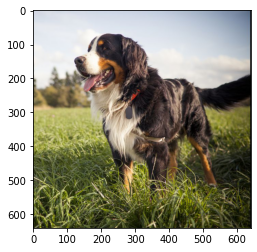

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image("images/large_dog.jpg")

plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [4]:
model = models.inception_v3(pretrained=True)

In [5]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [6]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [7]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.91473156, 239, 'Bernese_mountain_dog'),
 (0.051834784, 240, 'Appenzeller'),
 (0.020381039, 241, 'EntleBucher'),
 (0.013044636, 238, 'Greater_Swiss_Mountain_dog'),
 (1.7456049e-06, 214, 'Gordon_setter'))

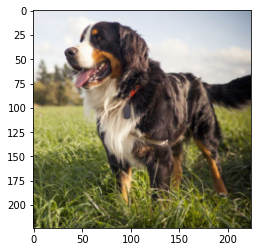

In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

plt.imshow(np.array(pill_transf(img)))

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm('slic', n_segments=35, compactness=80)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=400,
                                         segmentation_fn= segmenter) # number of images that will be sent to classification function

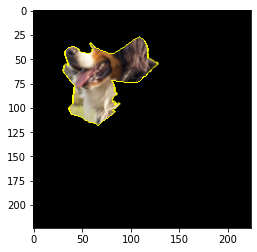

In [12]:
from skimage.segmentation import mark_boundaries

temp, mask_lime = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask_lime)
plt.imshow(img_boundry1)


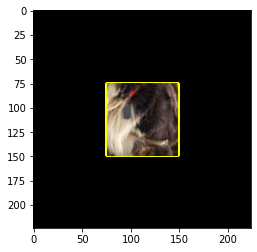

In [13]:
# Dummy
mask_dummy = np.zeros((224,224))
for i in range(224):
    for j in range(224):
        if i > 224/3 and i < 2*224/3 and j > 224/3 and j < 2*224/3:
            mask_dummy[i,j] = 1

temp_dummy = np.array(pill_transf(img)).copy()
for i in range(temp_dummy.shape[2]):
    temp_dummy[:,:,i] = temp_dummy[:,:,i] * mask_dummy
    
plt.imshow(mark_boundaries(temp_dummy/255.0, mask_dummy.astype(int),  outline_color=None))

In [14]:
from advertorch.attacks import CarliniWagnerL2AttackMask
from advertorch.utils import  _get_norm_batch as get_norm

In [15]:
def get_torch_mask(mask):
    mask_ = 1 - mask
    torch_mask = torch.from_numpy(mask_)
    torch_mask = torch_mask.unsqueeze(0)
    torch_mask = torch_mask.unsqueeze(0)
    torch_mask = torch_mask.repeat(1, 3, 1, 1)
#     print(torch_mask.shape)
    return torch_mask.float()

In [16]:
torch_mask_lime = get_torch_mask(mask_lime)
torch_mask_dummy = get_torch_mask(mask_dummy)

In [17]:
adversary = CarliniWagnerL2AttackMask(model, 1000, learning_rate=0.001, clip_min=img_t.min().item(), 
                                      clip_max=img_t.max().item(), max_iterations=1000)

In [18]:
import time
from advertorch.context import ctx_noparamgrad_and_eval

start = time.time()
label = torch.tensor([test_pred.squeeze().argmax()])
with ctx_noparamgrad_and_eval(model):
    adv_lime = adversary.perturb(img_t, torch_mask_lime, label)
print("Duration: ", time.time() - start)

Duration:  378.59536480903625


In [19]:
start = time.time()
label = torch.tensor([test_pred.squeeze().argmax()])
with ctx_noparamgrad_and_eval(model):
    adv_dummy = adversary.perturb(img_t, torch_mask_dummy, label)
print("Duration: ", time.time() - start)

Duration:  355.982390165329


In [20]:
start = time.time()
label = torch.tensor([test_pred.squeeze().argmax()])
with ctx_noparamgrad_and_eval(model):
    adv_zero = adversary.perturb(img_t, torch.ones_like(torch_mask_dummy), label)
print("Duration: ", time.time() - start)

Duration:  359.2622721195221


In [21]:
diff_zero = img_t - adv_zero
c_zero = get_norm(diff_zero, 2)
print("C-eval for empty mask: ", c_zero.item())

diff_lime = img_t - adv_lime
c_lime = get_norm(diff_lime, 2)
print("C-eval for Lime: ", c_lime.item())

diff_dummy = img_t - adv_dummy
c_dummy = get_norm(diff_dummy, 2)
print("C-eval for square: ", c_dummy.item())

C-eval for empty mask:  0.5411664247512817
C-eval for Lime:  0.6297465562820435
C-eval for square:  0.6153924465179443


In [22]:
model.eval()
print(model(img_t).argmax().item())
print(model(adv_zero).argmax().item())
print(model(adv_lime).argmax().item())
print(model(adv_dummy).argmax().item())

239
240
240
240


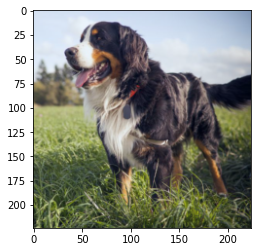

In [23]:
def convert_back_for_view(torch_image):
    x = torch_image.clone()
    _,c,w,h = x.shape
    y = np.zeros((w,h,c))
    for i in range(c):
        y[:,:,i] = x[0,i,:,:]
    y = y - y.min()
    y = y/y.max()
    return y

plt.imshow(convert_back_for_view(adv_lime))

Text(0.5, 1.0, 'Norm of difference: 0.615')

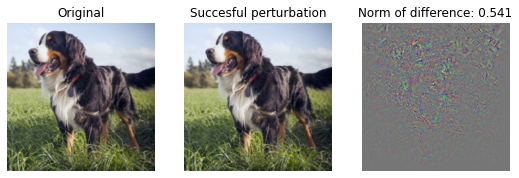

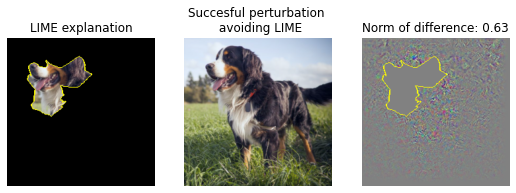

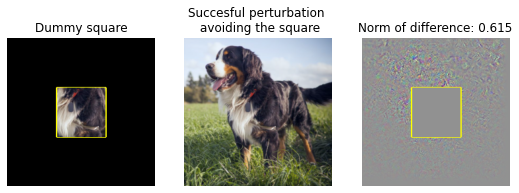

In [24]:
# Display

original = convert_back_for_view(img_t)
adv = convert_back_for_view(adv_zero)
z = adv-original
fig1 = plt.figure(figsize = (9,9))
a = fig1.add_subplot(1, 3, 1)
plt.axis('off')
imgplot = plt.imshow(original)
a.set_title('Original')
a = fig1.add_subplot(1, 3, 2)
plt.axis('off')
imgplot = plt.imshow(adv)
a.set_title('Succesful perturbation')
a = fig1.add_subplot(1, 3, 3)
plt.axis('off')
vmax = z.max()
vmin = z.min()
imgplot = plt.imshow((z - vmin )/(vmax-vmin))
a.set_title('Norm of difference: ' + str(round(c_zero.item(),3)))

temp_lime = original.copy()
for i in range(temp_lime.shape[2]):
    temp_lime[:,:,i] = temp_lime[:,:,i] * mask_lime
adv_l = convert_back_for_view(adv_lime)
z = original - adv_l
fig2 = plt.figure(figsize = (9,9))
a = fig2.add_subplot(1, 3, 1)
plt.axis('off')
imgplot = plt.imshow(mark_boundaries(temp_lime, mask_lime))
a.set_title('LIME explanation')
a = fig2.add_subplot(1, 3, 2)
plt.axis('off')
imgplot = plt.imshow(adv_l)
a.set_title('Succesful perturbation \n avoiding LIME')
a = fig2.add_subplot(1, 3, 3)
plt.axis('off')
vmax = z.max()
vmin = z.min()
imgplot = plt.imshow(mark_boundaries((z - vmin )/(vmax-vmin), mask_lime))
a.set_title('Norm of difference: ' + str(round(c_lime.item(),3)))

temp_dummy = original.copy()
for i in range(temp_lime.shape[2]):
    temp_dummy[:,:,i] = temp_dummy[:,:,i] * mask_dummy
adv_d = convert_back_for_view(adv_dummy)
z = original - adv_d
fig3 = plt.figure(figsize = (9,9))
a = fig3.add_subplot(1, 3, 1)
plt.axis('off')
imgplot = plt.imshow(mark_boundaries(temp_dummy, mask_dummy.astype(int)))
a.set_title('Dummy square')
a = fig3.add_subplot(1, 3, 2)
plt.axis('off')
imgplot = plt.imshow(adv_d)
a.set_title('Succesful perturbation \n avoiding the square')
a = fig3.add_subplot(1, 3, 3)
plt.axis('off')
vmax = z.max()
vmin = z.min()
imgplot = plt.imshow(mark_boundaries((z - vmin )/(vmax-vmin), mask_dummy.astype(int)))
a.set_title('Norm of difference: ' + str(round(c_dummy.item(),3)))

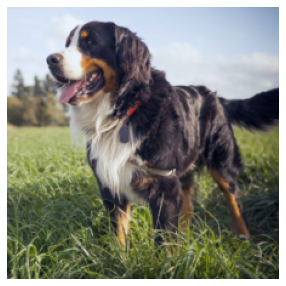

In [25]:
original = convert_back_for_view(img_t)
adv = convert_back_for_view(adv_zero)
fig1 = plt.figure(figsize = (5,5))
a = fig1.add_subplot(1, 1, 1)
plt.axis('off')
imgplot = plt.imshow(original)
# a.set_title('Original')
plt.savefig('results/Original.png', bbox_inches='tight')

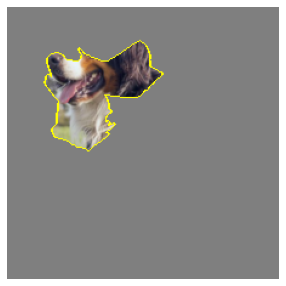

In [26]:
temp_lime = original.copy()
temp_lime = temp_lime - 0.5
for i in range(temp_lime.shape[2]):
    temp_lime[:,:,i] = temp_lime[:,:,i] * mask_lime
temp_lime = temp_lime + 0.5
adv_l = convert_back_for_view(adv_lime)
fig2 = plt.figure(figsize = (5,5))
a = fig2.add_subplot(1, 1, 1)
plt.axis('off')
imgplot = plt.imshow(mark_boundaries(temp_lime, mask_lime))
# a.set_title('LIME explanation')
plt.savefig('results/LIME_explanation.png', bbox_inches='tight') 

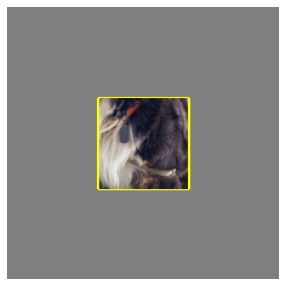

In [27]:
temp_dummy = original.copy()
temp_dummy = temp_dummy - 0.5
for i in range(temp_lime.shape[2]):
    temp_dummy[:,:,i] = temp_dummy[:,:,i] * mask_dummy
temp_dummy = temp_dummy + 0.5
adv_d = convert_back_for_view(adv_dummy)
fig3 = plt.figure(figsize = (5,5))
a = fig3.add_subplot(1, 1, 1)
plt.axis('off')
imgplot = plt.imshow(mark_boundaries(temp_dummy, mask_dummy.astype(int)))
# a.set_title('Dummy square')
plt.savefig('results/square_explanation.png',bbox_inches='tight')

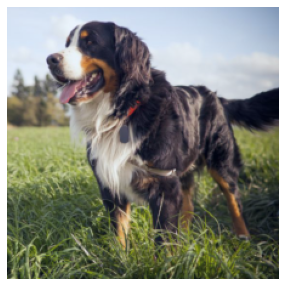

In [28]:
adv_l = convert_back_for_view(adv_lime)
fig4 = plt.figure(figsize = (5,5))
a = fig4.add_subplot(1, 1, 1)
plt.axis('off')
imgplot = plt.imshow(adv_l)
plt.savefig('results/adv_LIME.png',bbox_inches='tight')

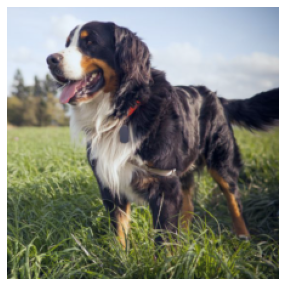

In [29]:
adv_d = convert_back_for_view(adv_dummy)
fig5 = plt.figure(figsize = (5,5))
a = fig5.add_subplot(1, 1, 1)
plt.axis('off')
imgplot = plt.imshow(adv_d)
plt.savefig('results/adv_square.png',bbox_inches='tight')

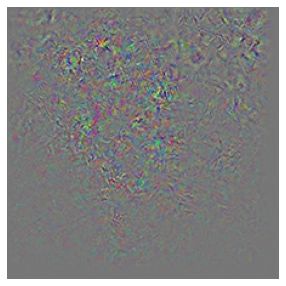

In [30]:
original = convert_back_for_view(img_t)
adv = convert_back_for_view(adv_zero)
z = adv-original
fig6 = plt.figure(figsize = (5,5))
a = fig6.add_subplot(1, 1, 1)
plt.axis('off')
vmax = z.max()
vmin = z.min()
imgplot = plt.imshow((z - vmin )/(vmax-vmin))
# a.set_title('Norm of difference: ' + str(round(c_zero.item(),3)))
plt.savefig('results/diff_zero.png',bbox_inches='tight')

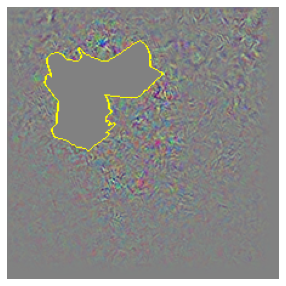

In [31]:
adv_l = convert_back_for_view(adv_lime)
z = original - adv_l
fig7 = plt.figure(figsize = (5,5))
a = fig7.add_subplot(1, 1, 1)
plt.axis('off')
vmax = z.max()
vmin = z.min()
imgplot = plt.imshow(mark_boundaries((z - vmin )/(vmax-vmin), mask_lime))
# a.set_title('Norm of difference: ' + str(round(c_lime.item(),3)))
plt.savefig('results/diff_lime.png',bbox_inches='tight')

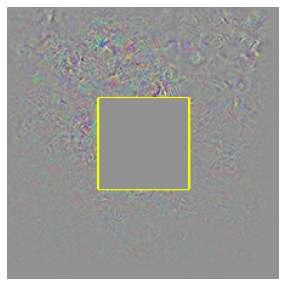

In [32]:
adv_d = convert_back_for_view(adv_dummy)
z = original - adv_d
fig8 = plt.figure(figsize = (5,5))
a = fig8.add_subplot(1, 1, 1)
plt.axis('off')
vmax = z.max()
vmin = z.min()
imgplot = plt.imshow(mark_boundaries((z - vmin )/(vmax-vmin), mask_dummy.astype(int)))
# a.set_title('Norm of difference: ' + str(round(c_dummy.item(),3)))
plt.savefig('results/diff_dummy.png',bbox_inches='tight')